In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import logging
import warnings
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [89]:
from src.io.cache_io import temp_dir
from src.io.data_io import DataFile
from src.loggers import set_console_handler_level
from src.managers.data_managers import CrisprScreenDataManager
from src.models.speclet_eight import SpecletEight
from src.plot.color_pal import SeabornColor
from src.plot.plotnine_helpers import set_gg_theme

In [90]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.INFO)
set_gg_theme()
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1026
np.random.seed(RANDOM_SEED)

In [91]:
dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_SUBSAMPLE)
sp8 = SpecletEight("design-model", data_manager=dm, root_cache_dir=temp_dir())

[10/13/21 11:14:09] INFO     Creating a new SpecletEight     speclet_eight.py:65
                             object.                                            
                    INFO     Adding new transformation.     data_managers.py:171


In [92]:
sp8.build_model()

[10/13/21 11:14:10] INFO     Calling                        speclet_model.py:205
                             `model_specification()`                            
                             method.                                            
                    INFO     Creating SpecletEight model.    speclet_eight.py:96
                    INFO     Getting data - reading from    data_managers.py:126
                             file.                                              
[10/13/21 11:14:11] WARNING  Dropping 0 sgRNA that map to        achilles.py:616
                             multiple genes.                                    
                    INFO     Adding                    feature_engineering.py:73
                             'rna_expr_gene_lineage'                            
                             column.                                            
[10/13/21 11:14:13] INFO     Number of data points: 960     speclet_eight.py:100
                    INFO    

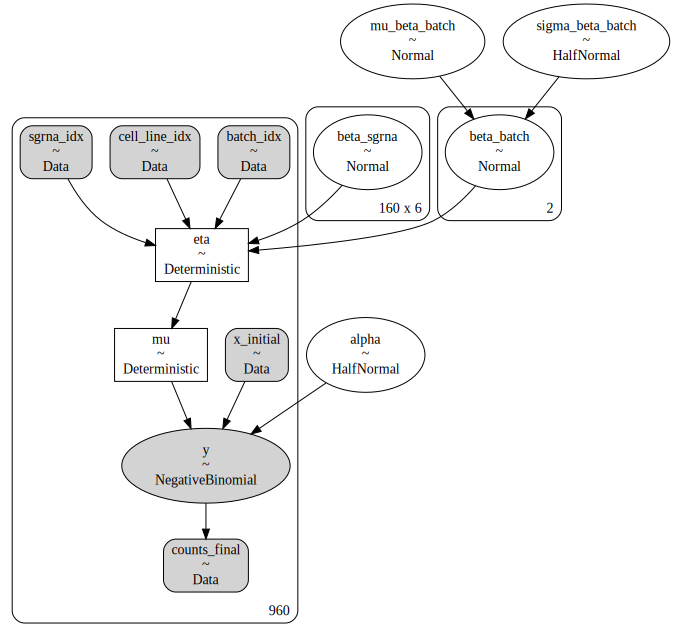

In [93]:
pm.model_to_graphviz(sp8.model)

In [94]:
sp8_mcmc_post = sp8.mcmc_sample_model(
    draws=1000,
    tune=1000,
    chains=2,
    cores=2,
    target_accept=0.85,
    prior_pred_samples=500,
    random_seed=RANDOM_SEED,
    ignore_cache=True,
)

[10/13/21 11:14:51] INFO     Beginning MCMC sampling.       speclet_model.py:304


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_batch, sigma_beta_batch, mu_beta_batch, beta_sgrna]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 88 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[10/13/21 11:16:55] INFO     Finished MCMC sampling -       speclet_model.py:316
                             caching results.                                   
                    INFO     Caching InferenceData to '/Us cache_managers.py:230
                             ers/admin/Lab_Projects/specle                      
                             t/temp/design-model/mcmc/infe                      
                             rence-data.nc'.                                    


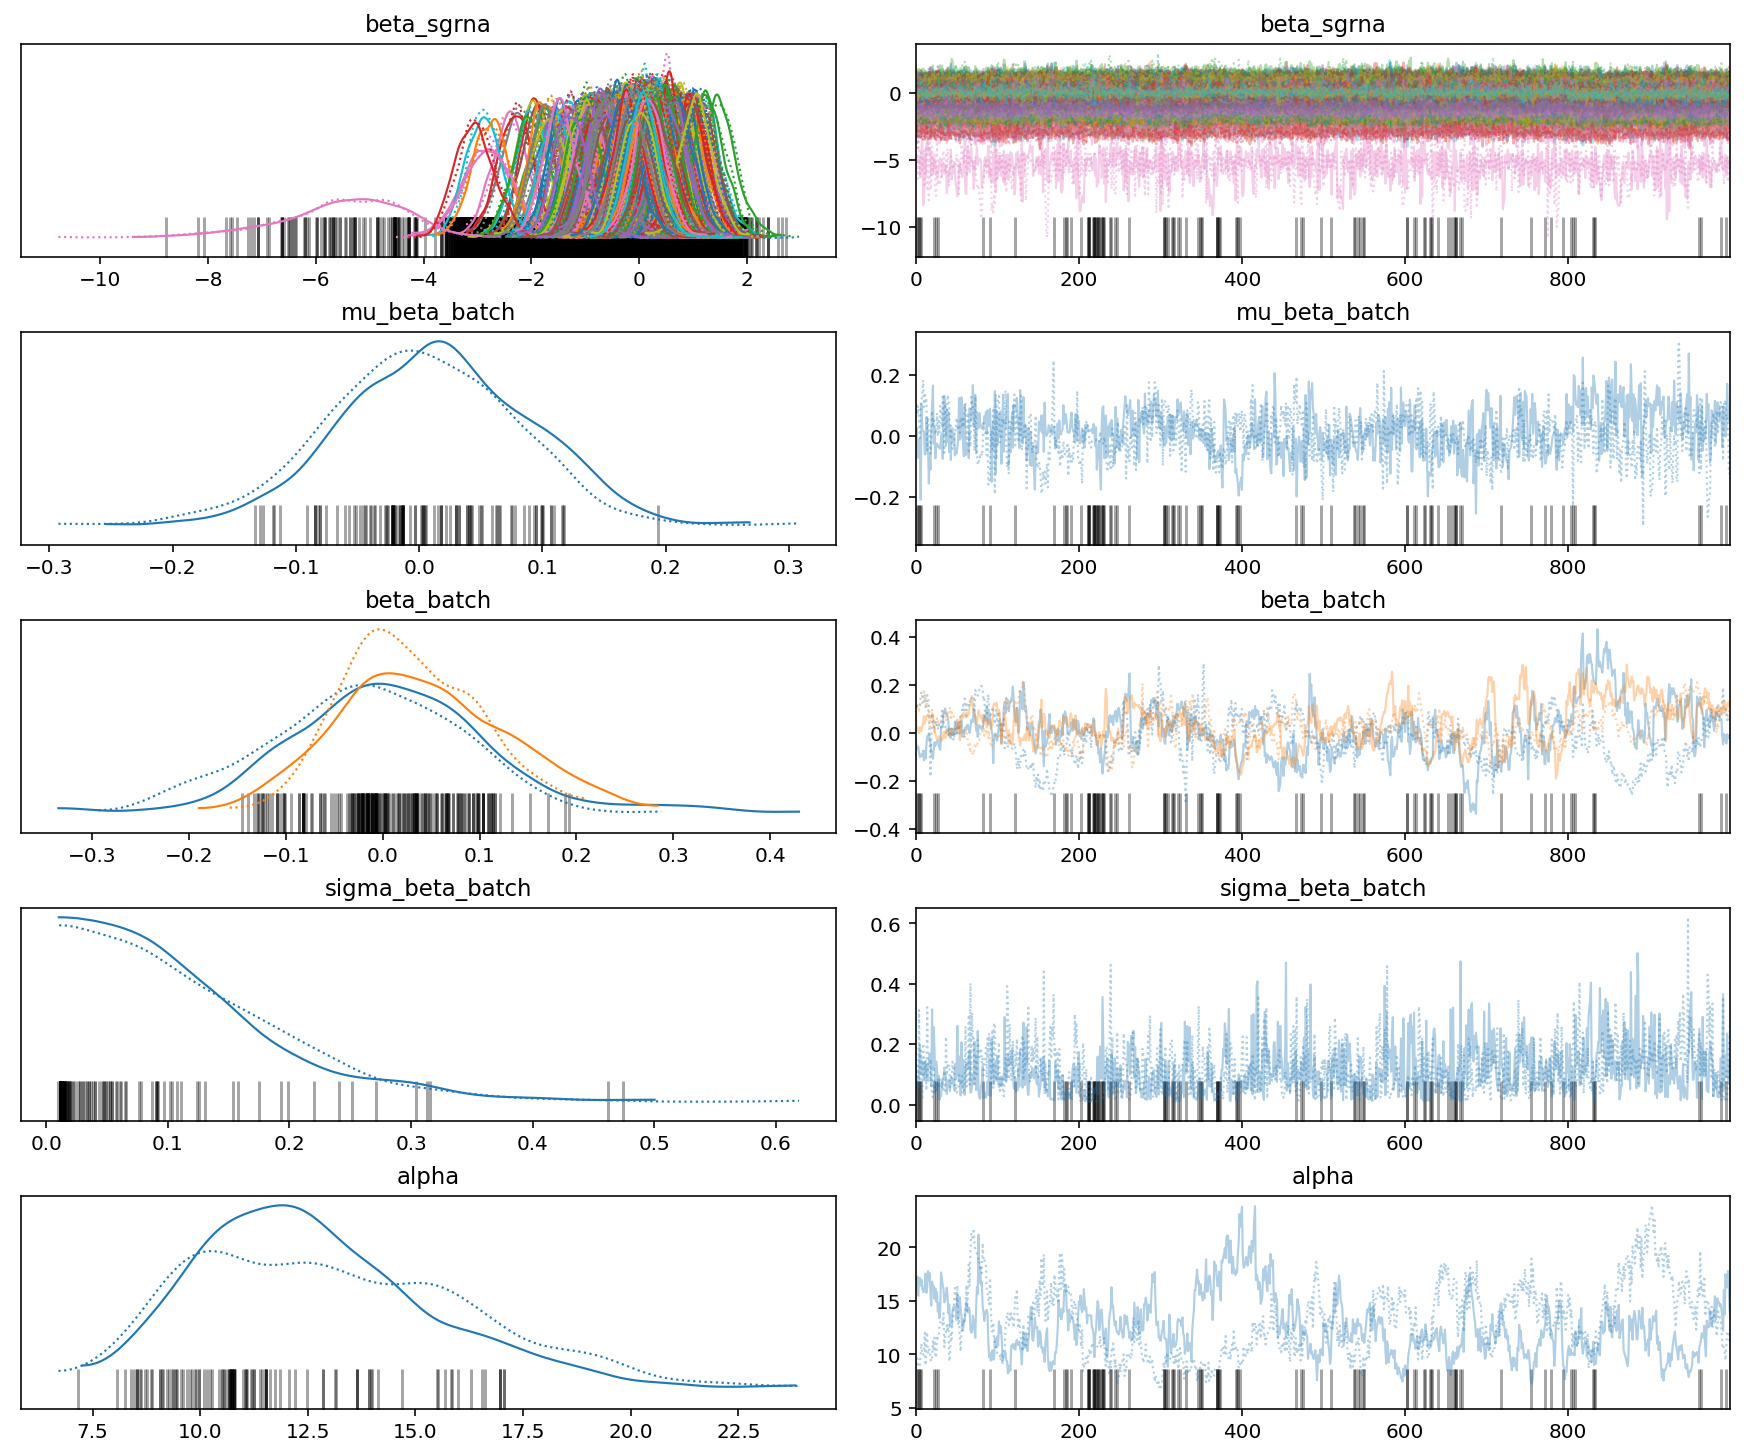

In [95]:
az.plot_trace(sp8_mcmc_post, var_names=["alpha", "beta"], filter_vars="like");

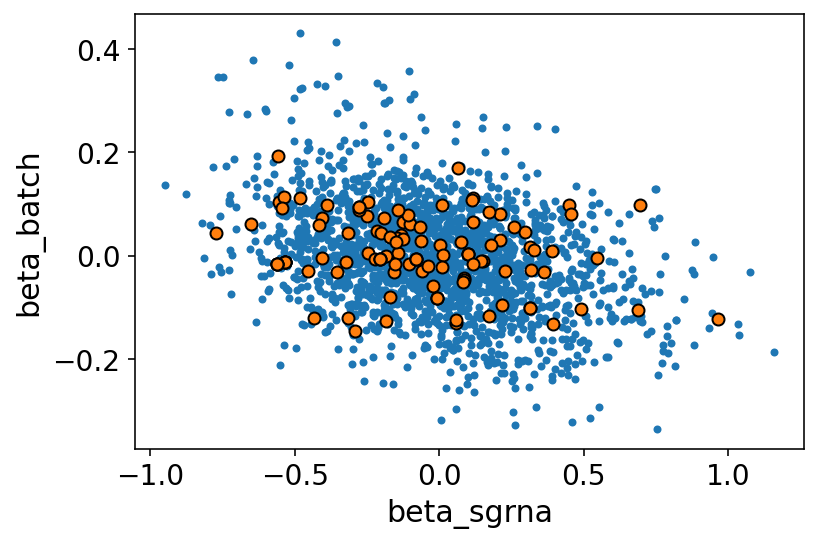

In [103]:
az.plot_pair(
    sp8_mcmc_post,
    var_names=["beta_sgrna", "beta_batch"],
    coords={"sgrna": "AGCTGAGCGCAGGGACCGGG", "batch": "2", "cell_line": "ACH-000007"},
    divergences=True,
);

---

notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m